In [1]:
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [2]:
import tensorflow as tf
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import VGG16, DenseNet169
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
#from classification_models.tfkeras import Classifiers
from datetime import datetime
%load_ext tensorboard

In [3]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('acc') >= 0.96):   
            print("Reached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [4]:
EPOCHS =50
INIT_LR = 3e-3
BS =32
default_image_size = tuple((224, 224))
image_size = 0
width=224
height=224
depth=3
train_dir=r"C:\Users\Glau\Desktop\Burn_Aug_bin"
#valid_dir=r"C:\Users\Glau\Desktop\DP\Pediastrum_cnn\Test"
train_folder=listdir(train_dir)
#valid_folder=listdir(valid_dir)

In [5]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
callbacks = MyCustomCallback()

In [7]:
train_image_list, train_image_label=[],[]
for disease_folder in train_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{train_dir}/{disease_folder}")
    #print(disease_img_folder)
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]:    
        image_directory = f"{train_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpeg") == True or image_directory.endswith(".jpg") == True or  image_directory.endswith(".png") == True:
            train_image_list.append(convert_image_to_array(image_directory))
            train_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing graft ...
processing non-graft ...
[INFO] Image loading completed


In [8]:
print(len(train_image_label))

4000


In [9]:
label_binarizer = LabelBinarizer()
bin_train_image_labels = label_binarizer.fit_transform(train_image_label)
#bin_valid_image_labels = label_binarizer.fit_transform(valid_image_label)
pickle.dump(label_binarizer,open('Label_Instance_burn_labe16.pk', 'wb'))
n_classes = len(label_binarizer.classes_)

In [10]:
print(len(bin_train_image_labels))

4000


In [11]:
np_train_image_list = np.array(train_image_list, dtype=np.float32) / 255.0

In [12]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [13]:
# coding: utf8
from tensorflow.keras import layers
from tensorflow.keras import models


#
# image dimensions
#

img_height = 224
img_width = 224
img_channels = 3

#
# network params
#

cardinality = 32


def residual_network(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:

        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):#3
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 64, 128, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):#4
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 128, 256, _strides=strides)

    # conv4
    for i in range(6):#6
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv5
    for i in range(3):#3
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 512, 2048, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(2,activation='softmax')(x)

    return x


image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = residual_network(image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 256 19456       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 256 1024        conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 112, 112, 256 0           batch_normalization[0][0]        
______________________________________________________________________________________________

__________________________________________________________________________________________________
lambda_438 (Lambda)             (None, 14, 14, 16)   0           leaky_re_lu_40[0][0]             
__________________________________________________________________________________________________
lambda_439 (Lambda)             (None, 14, 14, 16)   0           leaky_re_lu_40[0][0]             
__________________________________________________________________________________________________
lambda_440 (Lambda)             (None, 14, 14, 16)   0           leaky_re_lu_40[0][0]             
__________________________________________________________________________________________________
lambda_441 (Lambda)             (None, 14, 14, 16)   0           leaky_re_lu_40[0][0]             
__________________________________________________________________________________________________
lambda_442 (Lambda)             (None, 14, 14, 16)   0           leaky_re_lu_40[0][0]             
__________

In [14]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

print("[INFO] training network...")

[INFO] training network...


In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,classification_report 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer

In [16]:
conf_matrix_list_of_arrays = []
#loss_per_fold = []
seed = 13   # for reproducibility you can change it. 
np.random.seed(seed)
roundlabel=[]
test=[]
idtest=[]
x_validate=[]
kfold = KFold(5, True, seed)
for train_idx, val_idx in kfold.split(np_train_image_list, y=bin_train_image_labels):
    #print('train: %s, val: %s' % (train_idx, val_idx))
    x_train, x_val = np_train_image_list[train_idx], np_train_image_list[val_idx]
    y_train, y_val= bin_train_image_labels[train_idx], bin_train_image_labels[val_idx]
    history=model.fit(x_train, y_train,
                  validation_data=(x_val, y_val),
                  batch_size=BS,
                  epochs=EPOCHS, verbose=1        
                  )
    ycalculated = model.predict(x_val)
    yhat_classes =np.argmax(ycalculated,axis=1)
    rounded_labels=np.argmax(y_val,axis=1)                           
    conf_matrix = confusion_matrix(y_val,yhat_classes)
    conf_matrix_list_of_arrays .append(conf_matrix)
    roundlabel.append(rounded_labels)
    test.append(yhat_classes)
    idtest.append(val_idx)
    
print('Score per fold')
for i in range(0, len(conf_matrix_list_of_arrays)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1}  - Accuracy: {conf_matrix_list_of_arrays[i]}%')   

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 83s 26ms/sample - loss: 0.9189 - accuracy: 0.8238 - val_loss: 15.7228 - val_accuracy: 0.5288
Epoch 2/50
3200/3200 [==============================] - 39s 12ms/sample - loss: 0.2213 - accuracy: 0.9103 - val_loss: 0.8510 - val_accuracy: 0.6662
Epoch 3/50
3200/3200 [==============================] - 39s 12ms/sample - loss: 0.2700 - accuracy: 0.8944 - val_loss: 0.4611 - val_accuracy: 0.8300
Epoch 4/50
3200/3200 [==============================] - 39s 12ms/sample - loss: 0.1925 - accuracy: 0.9331 - val_loss: 0.3876 - val_accuracy: 0.9013
Epoch 5/50
3200/3200 [==============================] - 40s 12ms/sample - loss: 0.1596 - accuracy: 0.9441 - val_loss: 1.9639 - val_accuracy: 0.6600
Epoch 6/50
3200/3200 [==============================] - 40s 13ms/sample - loss: 0.1685 - accuracy: 0.9422 - val_loss: 1.3946 - val_accuracy: 0.6075
Epoch 7/50
3200/3200 [==============================] - 40s 12ms

3200/3200 [==============================] - 40s 12ms/sample - loss: 0.0051 - accuracy: 0.9975 - val_loss: 0.9897 - val_accuracy: 0.8888
Epoch 10/50
3200/3200 [==============================] - 40s 12ms/sample - loss: 0.0296 - accuracy: 0.9897 - val_loss: 0.0193 - val_accuracy: 0.9937
Epoch 11/50
3200/3200 [==============================] - 40s 12ms/sample - loss: 0.0577 - accuracy: 0.9878 - val_loss: 0.8895 - val_accuracy: 0.9600
Epoch 12/50
3200/3200 [==============================] - 40s 12ms/sample - loss: 0.0155 - accuracy: 0.9950 - val_loss: 0.0968 - val_accuracy: 0.9513
Epoch 13/50
3200/3200 [==============================] - 39s 12ms/sample - loss: 0.0107 - accuracy: 0.9966 - val_loss: 0.0849 - val_accuracy: 0.9563
Epoch 14/50
3200/3200 [==============================] - 40s 12ms/sample - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.0102 - val_accuracy: 0.9987
Epoch 15/50
3200/3200 [==============================] - 39s 12ms/sample - loss: 0.0721 - accuracy: 0.9781 - val_loss:

Epoch 13/50
3200/3200 [==============================] - 40s 12ms/sample - loss: 0.0063 - accuracy: 0.9981 - val_loss: 18.9576 - val_accuracy: 0.6800
Epoch 14/50
3200/3200 [==============================] - 40s 12ms/sample - loss: 0.0361 - accuracy: 0.9891 - val_loss: 0.0450 - val_accuracy: 0.9837
Epoch 15/50
3200/3200 [==============================] - 40s 12ms/sample - loss: 0.0018 - accuracy: 0.9994 - val_loss: 2.4346e-04 - val_accuracy: 1.0000
Epoch 16/50
3200/3200 [==============================] - 40s 12ms/sample - loss: 5.0414e-04 - accuracy: 1.0000 - val_loss: 6.1460e-05 - val_accuracy: 1.0000
Epoch 17/50
3200/3200 [==============================] - 39s 12ms/sample - loss: 7.7569e-04 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 0.9987
Epoch 18/50
3200/3200 [==============================] - 39s 12ms/sample - loss: 6.6581e-04 - accuracy: 1.0000 - val_loss: 3.1328e-05 - val_accuracy: 1.0000
Epoch 19/50
3200/3200 [==============================] - 40s 12ms/sample - loss: 

Epoch 16/50
3200/3200 [==============================] - 40s 12ms/sample - loss: 1.9672e-04 - accuracy: 1.0000 - val_loss: 4.4867e-06 - val_accuracy: 1.0000
Epoch 17/50
3200/3200 [==============================] - 40s 12ms/sample - loss: 4.5883e-04 - accuracy: 0.9997 - val_loss: 6.4933e-05 - val_accuracy: 1.0000
Epoch 18/50
3200/3200 [==============================] - 40s 12ms/sample - loss: 1.5799e-04 - accuracy: 1.0000 - val_loss: 4.1239e-06 - val_accuracy: 1.0000
Epoch 19/50
3200/3200 [==============================] - 39s 12ms/sample - loss: 8.3270e-05 - accuracy: 1.0000 - val_loss: 2.5268e-06 - val_accuracy: 1.0000
Epoch 20/50
3200/3200 [==============================] - 40s 12ms/sample - loss: 8.5714e-04 - accuracy: 0.9994 - val_loss: 1.4232 - val_accuracy: 0.8600
Epoch 21/50
3200/3200 [==============================] - 40s 12ms/sample - loss: 0.0301 - accuracy: 0.9919 - val_loss: 0.1271 - val_accuracy: 0.9712
Epoch 22/50
3200/3200 [==============================] - 40s 12ms/samp

In [22]:
for i in range(len(test[0])):
    print(test[0][i])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
1
0
0
0
1
0
1
0
0
1
0
0
1
0
0
1
0
0
0
1
0
0
1
1
1
0
0
0
0
1
1
0
0
0
0
1
1
1
0
1
1
0
1
0
0
0
1
1
0
0
1
0
0
1
0
0
1
0
0
1
0
1


In [23]:
for i in range(len(idtest[0])):
    print(idtest[0][i])


0
18
19
22
23
25
27
28
29
30
34
35
52
56
67
70
79
83
85
86
93
114
117
127
131
142
144
149
150
152
165
167
171
176
185
189
195
202
204
205
215
216
217
220
224
229
230
231
232
233
234
247
250
251
264
265
268
278
280
285
287
291
292
296
299
303
304
316
319
320
328
334
339
346
350
351
357
359
366
369
394
402
404
409
413
414
415
418
423
425
431
433
438
440
442
444
445
448
449
452
455
458
459
460
474
476
483
491
497
506
510
513
514
519
522
523
524
532
540
542
549
555
572
573
574
578
585
590
594
603
608
620
622
624
629
632
634
640
646
647
648
656
660
666
667
669
682
685
689
690
696
699
704
706
709
721
732
733
738
758
760
763
764
765
776
780
782
784
792
797
799
801
803
809
813
815
818
819
821
825
837
838
841
845
847
859
862
864
871
879
890
896
899
901
905
909
912
919
921
923
925
928
929
932
934
938
944
946
949
954
956
959
970
971
977
981
982
990
1005
1009
1010
1016
1018
1019
1022
1027
1036
1054
1057
1063
1065
1066
1069
1070
1077
1080
1086
1089
1090
1093
1095
1099
1104
1108
1112
1116
1122
1124


In [30]:
cm=conf_matrix_list_of_arrays[0]
print(cm)

[[423   0]
 [  0 377]]


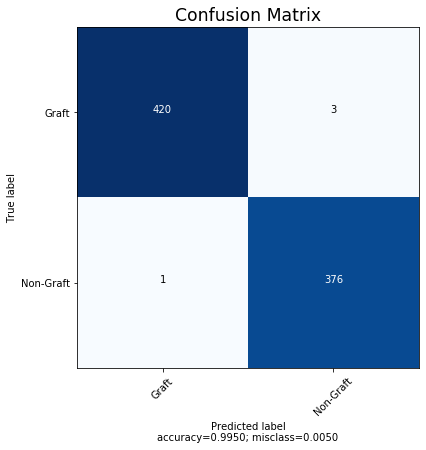

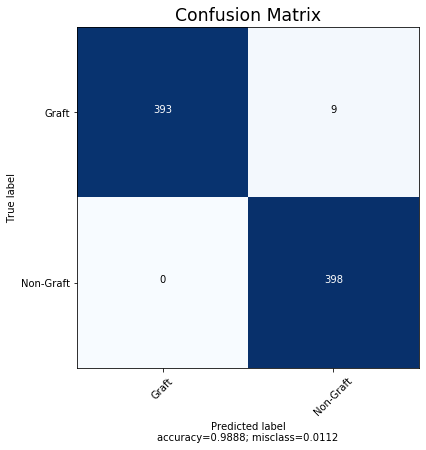

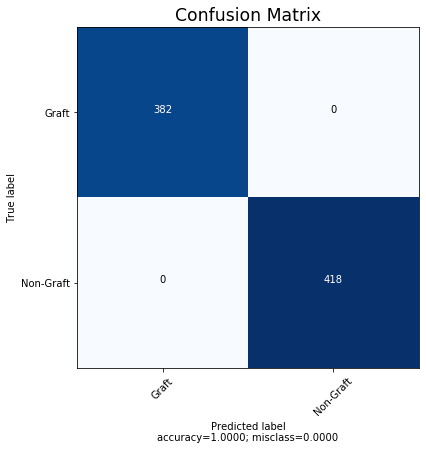

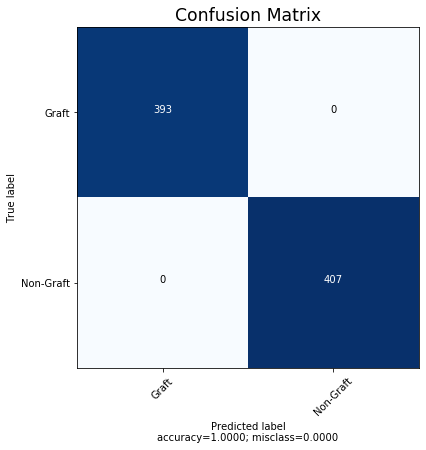

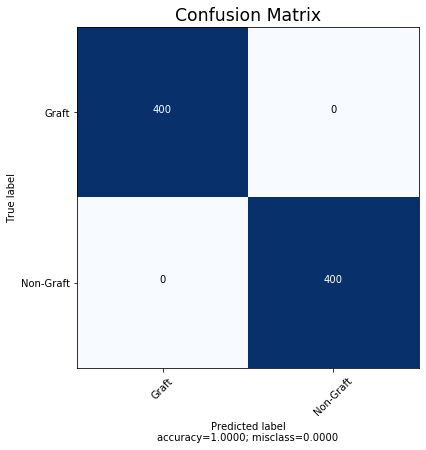

In [17]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
for i in range(5):
    plot_confusion_matrix(conf_matrix_list_of_arrays[i], 
                      normalize = False,
                      target_names = ['Graft', 'Non-Graft'],
                      title        = "Confusion Matrix")

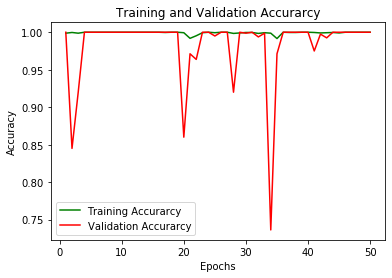

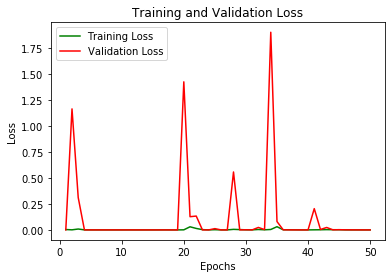

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training Accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation Accurarcy')
plt.title('Training and Validation Accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'lw' is not defined

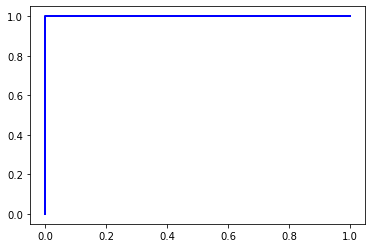

In [22]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_val,yhat_classes)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', inestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [23]:
class_to_label_map = { 0: 'Graft', 1: 'non-Graft'}

In [26]:
import seaborn as sns
def plot_multiclass_roc(y_test, y_score, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(rounded_labels,yhat_classes, n_classes=2, figsize=(16, 10))

IndexError: too many indices for array